In [1]:
import matplotlib.pyplot as plt
import numpy as np
from optix import *

def custom_str_repr(gb: GaussianBeam) -> str:
    return f"""
    waist_loc\t=\t{gb.waist_location*10**2} cm
    waist_rad\t=\t{gb.waist_radius*10**3} mm
    ray_range\t=\t{gb.rayleigh_range*10**3} mm
    divergence\t=\t{gb.divergence*10**3} mrad
    """
GaussianBeam.__str__ = custom_str_repr

# Gaussovský svazek na výstupu z vlákna
Vlákno je označeno OE-000592. Bohužel na stránce TOPTICY žádné takové nanabízejí. Proto počítám se sepcifikami vláken https://www.toptica.com/products/optical-isolators-photonicals/photonicals/optical-fibers.

Pro získání Rayleigho vzdálenosti využit vzorec https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=14204


    waist_loc	=	0 cm
    waist_rad	=	0.00175 mm
    ray_range	=	0.02375587037436727 mm
    divergence	=	73.66600223110584 mrad
    


Text(0, 0.5, 'Beam diameter [mm]')

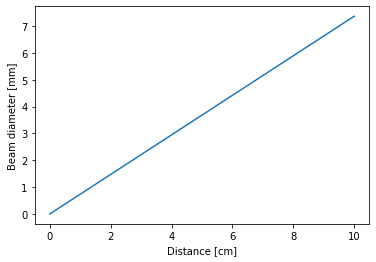

In [2]:
MFD = 3.5e-6
WAVE_LENGTH = 405e-9
w0 = MFD/2 
fiber_out = GaussianBeam(WAVE_LENGTH, w0=w0)
print(fiber_out)


z = np.linspace(0, 0.1, 100)
w = fiber_out.beam_radius(z)
plt.plot(z*10**2, w*10**3)
plt.xlabel("Distance [cm]")
plt.ylabel("Beam diameter [mm]")


# Šíření svazku krystalem
Předpoklad šíření podél osy $x$ přičemž čerpání je polarizováno horizontálně podél osy $y$. Posléze se generuje horizontální ($x$) a vertikální ($z$) fotony. Krystal od firmy Raicol má dimenze $1\times1\times2 mm$ a periodu pĺování $\Lambda = 10.025 \mu m$. Krystal KTP je dvojosý materiál s index lomu podél krystalografický os ($\lambda$ je v $\mu m$)
    $$ 
        n_x^2 = 3.29100 + \frac{0.04140}{\lambda^2 - 0.03978} + \frac{9.35522}{\lambda^2 - 31.45571} \\
        n_y^2 = 3.45018 + \frac{0.04341}{\lambda^2 - 0.04597} + \frac{16.98825}{\lambda^2 - 39.43799} \\
        n_z^2 = 4.59423 + \frac{0.06206}{\lambda^2 - 0.04763} + \frac{110.80672}{\lambda^2 - 86.12171}
    $$


Dle https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.053805 dochází k nejoptimálnější generaci SPDC při hodnotě kofokálního parametru $\xi_s \approx \xi_i \approx \xi_p \approx 2.84$. Přičemž platí, že 
    $$\xi_j = \frac{L}{k_j w_j^2},$$
kde $L$ je délka krystalu, $k_j$ je odpovídající vlnové číslo a $w_j$ je velikost krčku Gaussovského svazku. Tedy podmínka na velikost krčku je 
    $$w_j = \sqrt{\frac{L}{k_j \xi_j}} \approx \sqrt{\frac{L}{2.84 \cdot k_j }}, \quad k_j = \frac{\omega_j}{c} \cdot n_j(\omega_j).$$


In [3]:
LIGHT_SPEED = 299_792_458
def KTP_n_x(wl) -> float:
    return math.sqrt(3.29100 + 0.04140 / (wl**2 - 0.03978) + 9.35522 / (wl**2 - 31.45571))

def KTP_n_y(wl) -> float:
    return math.sqrt(3.45018 + 0.04341 / (wl**2 - 0.04597) + 16.98825 / (wl**2 - 39.43799))

def KTP_n_z(wl) -> float:
    return math.sqrt(4.59423 + 0.06206 / (wl**2 - 0.04763) + 110.80672 / (wl**2 - 86.12171))

def to_freq(wl) -> float:
    """Converts wavelength to angular frequency"""
    return 2 * math.pi * LIGHT_SPEED / wl

def to_wavelength(freq) -> float:
    """Converts angular frequency to wavelength"""
    return 2 * math.pi * LIGHT_SPEED / freq

In [4]:
CRYSTAL_LENGTH = 2e-2 # 2cm krystal od Raicolu
FOCAL_PARAM = 2.84 #optimum 2.84

n_p = KTP_n_y(WAVE_LENGTH*10**(-3)) # Pump je horizontálne polarizovaný, vkládám v mikrometrech
n_s = KTP_n_y(WAVE_LENGTH*10**(-3)*2)
n_i = KTP_n_z(WAVE_LENGTH*10**(-3)*2)

omega_p = to_freq(WAVE_LENGTH)
omega_s = to_freq(WAVE_LENGTH * 2)
omega_i = to_freq(WAVE_LENGTH * 2)

# Vlnové číslo příslušné polarizace již v KTP krystalu
k_p = omega_p / LIGHT_SPEED * n_p  
k_s = omega_s / LIGHT_SPEED * n_s
k_i = omega_i / LIGHT_SPEED * n_i

# Optimální šířka krčku v krystalu příslušného svazku
w_p = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_p))
w_s = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_s))
w_i = math.sqrt(CRYSTAL_LENGTH / (FOCAL_PARAM * k_i))

focus_info = f"""
    n_p = {n_p}, omega_p = {omega_p}s^-1, k_p = {k_p}m^-1, w_p = {w_p*10**6} um
    n_s = {n_s}, omega_s = {omega_s}s^-1, k_s = {k_s}m^-1, w_s = {w_s*10**6} um
    n_i = {n_i}, omega_i = {omega_i}s^-1, k_i = {k_i}m^-1, w_i = {w_i*10**6} um
"""
print(f"Optimal focus in crystal of length {CRYSTAL_LENGTH*10**3}mm:")
print(focus_info)

Optimal focus in crystal of length 20.0mm:

    n_p = 1.4405242023903018, omega_p = 4650991524219391.0s^-1, k_p = 22348346.921223056m^-1, w_p = 17.751421063770742 um
    n_s = 1.4405242023903018, omega_s = 2325495762109695.5s^-1, k_s = 11174173.460611528m^-1, w_s = 25.104300419780017 um
    n_i = 1.4158532155790764, omega_i = 2325495762109695.5s^-1, k_i = 10982800.149690649m^-1, w_i = 25.322074799497845 um



# Propagace systémem

In [30]:
from __future__ import annotations
N_BK7 = 1.5302 # Na 405nm

class TheLayout(OpticalPath):
    d_c: float # Poloha kolimační čočky (zafixuji aby odpovídala ohnisku)
    f_c: float # Ohnisková vzdálenost kolimační čočky
    d_f: float # Poloha fokusační čočky
    f_f: float # Ohnisko fokusační čočky
    d_cr: float # Poloha středu krystalu

    COLIMATION_LENSES = {
    25e-3: PlanoConvexLens(R=13.1e-3, n=N_BK7, d=11.7e-3),             # <--- Thorlabs LA1951-A, 25mm
    35e-3: PlanoConvexLens(R=18e-3, n=N_BK7, d=7e-3),                  # <--- Thorlabs LA1027-A, 35mm
    50e-3: PlanoConvexLens(R=25.8e-3, n=N_BK7, d=5.3e-3)               # <--- ThorLabs LA1131-A, 50mm
    }

    FOCUSING_LENSES = [100e-3, 125e-3, 150e-3, 200e-3, 250e-3, 300e-3, 400e-3]
    
    def build(self):
        self._elements = []
        colimation_lens = self.COLIMATION_LENSES[self.f_c]
        self.d_c = colimation_lens.f
        self.append(FreeSpace(self.d_c))
        self.append(colimation_lens)                                        # <--- Kolimace

        self.append(FreeSpace(self.d_f))
        self.append(ThinLens(self.f_f))                                   # <--- Fokusace

        self.append(FreeSpace(self.d_cr - CRYSTAL_LENGTH/2))              # <--- Krystal
        self.append(FlatInterface(1, n_p))
        self.append(FreeSpace(CRYSTAL_LENGTH/2))

    def clone(self) -> TheLayout:
        l = TheLayout()
        l.d_c = self.d_c
        l.f_c = self.f_c
        l.d_f = self.d_f
        l.f_f = self.f_f
        l.d_cr = self.d_cr
        return l

    def __str__(self) -> str:
        return f"""
            d_col       =   {self.d_c},
            f_col       =   {self.f_c},
            d_focus     =   {self.d_f},
            f_focus     =   {self.f_f},
            d_crystal   =  {self.d_cr}
        """




## Optimalizace
Potřebujeme dosáhnout určité šířky krčku v krystalu (viz výpočty výše). K dispozici máme omezený počet čoček a mnoho stupňů volnosti tj. poloha kolimační čočky (d_c), ohnisko kolimační čočky (f_c), vzdálenost fokusační čočky (d_f), ohnisko fokusační čočky (f_f) a vzdálenost krystalu (d_cr). Jednoho stupně volnosti se lze zbavit předpokládáme-li vzdálenost kolimační čočky odpovídající jejému ohnisku. Zároveň se snažíme mít kolimační čočku s co nejmenším ohniskem, tudíž z dostupných čoček se nabízí pouze 3 25mm, 35mm a 50mm (už to je velice neoptimální). Pro fokusační čočky se omezíme na dostupné čočky v rozsahu od 100mm do 400mm. Takto máme tedy 21 možných setupů. 

Poslední 2 zbylé parametry d_f a d_cr tak již není těžké získat jelikož se na problém lze kouakt jako na funkci o těchto dvou proměných, která vrací opět 2 proměnné a to polohu krčku (w_loc) a jeho šířku (w_0). 
    $$
    f: [d_f, d_{cr}] \rightarrow [w_0, w_{loc}]
    $$
Na výstupní hodnoty máme podmínku a to aby se krček nacházel ve středu krystalu tj $L = d_c + d_f + d_cr + 1mm$ a $w_0$ odpovídala dříve spočtené optimálne šířce krčku v krystalu $w_0^{opt}$. Úloha hledání optimálně geometrie sestavy se tak redukuje na nalezení kořenů této funkce
    $$
    \vec{O}(d_f, d_{cr}) = f(d_f, d_{cr}) - [w_0^{opt}, L] = 0
    $$

In [38]:
from scipy.optimize import root
from sys import float_info
def is_valid_layout(l: TheLayout) -> bool:
    [l.d_c, l.d_f, l.d_cr] = sorted([l.d_c, l.d_f, l.d_cr])


gauss_in = fiber_out                    
layouts = []
for f_c in TheLayout.COLIMATION_LENSES:
    layout = TheLayout()
    layout.f_c = f_c
    for f_f in TheLayout.FOCUSING_LENSES:
        layout.f_f = f_f
        def O(x: tuple[float, float]) -> tuple[float, float]:
            """x: [d_f, d_cr] --> y: [w_0 - w_0^opt, w_loc - L]"""
            layout.d_f, layout.d_cr = x
            layout.build()
            assert False, "BUG! kod pod touto pdmínkou se nikdy nevykona! Stříli to tu na hovno hodnoty..."
            if not is_valid_layout(layout):
                return float_info.max, float_info.max
            gauss_out = layout.propagate(gauss_in)
            return gauss_out.waist_radius - w_p, layout.length - gauss_out.waist_location
        opt_result = root(O, [0.2, 0.4], tol = 0.00001)
        layout.d_f, layout.d_cr = opt_result.x
        if opt_result.success:
            layouts.append(layout.clone())

if len(layouts) == 0:
    print("Bohužel se nepodařilo nalést odpovídajcí sestavu :(")
else:         
    for l in layouts:
        print(l)

AssertionError: BUG! kod pod touto pdmínkou se nikdy nevykona! Stříli to tu na hovno hodnoty...